#**Predictive Maintenance** : **Data Analysis & Time-Series Forecasting**


In [67]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
telemetry_df = pd.read_csv("/content/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/PdM_errors.csv")
maint_df = pd.read_csv("/content/PdM_maint.csv")
failure_df = pd.read_csv("/content/PdM_failures.csv")
machines_df = pd.read_csv("/content/PdM_machines.csv")

#Date and Time Formatting, Sorting based on Date for better readability
tables = [telemetry_df,errors_df,maint_df,failure_df]
for df in tables:
  df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
  df.sort_values(["datetime","machineID"],inplace=True, ignore_index = True)

In [ ]:
failure_df.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1


**Telemetry Data**

For more simplicity we will select a machine data that consist of hourly average of voltage, rotation, pressure, and vibration collected from 100 Machines.



In [ ]:
#First few rows of Telemetry data for Machine 1
telemetry_df[telemetry_df.machineID==1].head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
100,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
200,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
300,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
400,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [ ]:
#Let's assume machineID as 10
print(f"Shape of the Telemetry Record: {telemetry_df.shape}")
df_sin = telemetry_df.loc[telemetry_df['machineID']==10].reset_index(drop=True)
df_sin.head(n=5)

Shape of the Telemetry Record: (876100, 6)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,10,158.421261,500.830885,119.750673,45.571344
1,2015-01-01 07:00:00,10,174.631951,356.928821,88.860999,35.245965
2,2015-01-01 08:00:00,10,158.777566,467.162159,84.382394,37.975278
3,2015-01-01 09:00:00,10,178.128852,438.376292,105.870821,40.836263
4,2015-01-01 10:00:00,10,176.497316,364.918330,98.148214,35.511013


# Model Selection

**Preparing Data Input and Output**
We are using LSTM algorithm. For experimenting, we will be using training data of 1 month containing 2015-03-20 period where failure happened to predict another failure which occure at 2015-05-21 according to failure record.

The feature we are going to use is Pressure reading and Timestamp.

In [69]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Selecting the time period around a specific date for analysis
target_date = "2015-01-02"
target_date_index = df_sin[df_sin['datetime'] == target_date].index[0]
start_period = target_date_index - 5*24  # 5 days before
end_period = target_date_index + 5*24    # 5 days after

def create_features(start, end):
    # Extract pressure data and timestamps
    pressure = df_sin.loc[start:end, 'pressure']
    timestamps = pd.to_datetime(df_sin.loc[start:end, 'datetime'])

    # One-hot encoding of hours and days of the week
    hours = timestamps.dt.hour  # Corrected to use .dt accessor for datetime properties
    weekdays = timestamps.dt.dayofweek  # Corrected to use .dt accessor for datetime properties
    hours_onehot = pd.get_dummies(hours).to_numpy()

    # Normalizing pressure data
    scaler = MinMaxScaler()
    normalized_pressure = scaler.fit_transform(pressure.values.reshape(-1,1))

    # Combining features
    features = np.concatenate([normalized_pressure, hours_onehot], axis=1)

    # Separating features (X) and target values (y)
    X = features[:-1]
    y = features[5:, 0].reshape(-1, 1)
    return X, y, scaler

X, y, pressure_scaler = create_features(start_period, end_period)


In [73]:
def shape_sequence(arr, step, start):
    # Create subsequences of length 'step' from the array starting at 'start'
    num_sequences = arr.shape[0] - start - step + 1
    return np.array([arr[i:i + step] for i in range(start, start + num_sequences)])

# Applying the function to shape the sequences
X_seq = shape_sequence(X, 5, 0)
y_seq = shape_sequence(y, 1, 0)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print("Training Data Shape: ", X_train.shape)
print("Validating Data Shape: ", X_val.shape)


Training Data Shape:  (107, 5, 25)
Validating Data Shape:  (27, 5, 25)




---



#**Creating Prediction Model**

Creating a simple 2-layer LSTM moel with input shape matching the shape of the data sequence provided.

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.losses as loss

def create_model(X_train, y_train):
  shape = X_train.shape[1]
  feat_length = X_train.shape[2]

  model = Sequential()
  model.add(LSTM(shape, activation='tanh', input_shape = (shape, feat_length), return_sequences=True))
  model.add(LSTM(shape, activation='tanh', input_shape = (shape, feat_length), return_sequences=True))
  model.add(LSTM(shape, activation = 'tanh',input_shape=(shape, feat_length), return_sequences=False))
  model.add(Dense(shape, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer=Adam(learning_rate=0.05), loss=loss.mean_squared_error)
  model.fit(X_train, y_train, verbose=1, epochs=200)
  return model

model = create_model(X_train, y_train)

Epoch 1/200
4/4 [==============================] - 6s 13ms/step - loss: 0.1400
Epoch 2/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0326
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0332
Epoch 4/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0279
Epoch 5/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0297
Epoch 6/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0285
Epoch 7/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0292
Epoch 8/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0283
Epoch 9/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0286
Epoch 10/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0284
Epoch 11/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0288
Epoch 12/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0285
Epoch 13/200
4/4 [==============================]

#**Checking Validation Result**

Model's performance with vaildation data

1/1 [==============================] - 1s 1s/step
Validation Error:  0.09405757


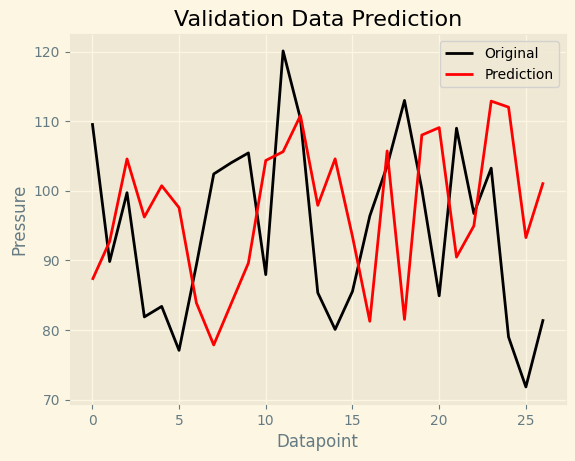

In [85]:
#Checking through trained model
y_pred = model.predict(X_val)
mse = MeanSquaredError()
val_er = mse(y_val.reshape(-1,1),y_pred)
print("Validation Error: ", val_er.numpy())

#Using Inverse Transformation for better Observation
plt.plot(pressure_scaler.inverse_transform(y_val.reshape(-1,1)),'k', label='Original')
plt.plot(pressure_scaler.inverse_transform(y_pred.reshape(-1,1)),'r', label='Prediction')
plt.ylabel("Pressure")
plt.xlabel("Datapoint")
plt.title("Validation Data Prediction")
plt.legend()
plt.show()



---



#**Checking Testing Result**

From the above plot we can see some of the data points are innacurate, which can be caused by the highly fluctuating nature of hourly data points, so we are checking whether the model can predict the sensor reading correctly in the event of anamolies.

Picking up date where failure occured:- 2015-05-21

11/11 [==============================] - 0s 3ms/step
Testing Error =  0.04210332


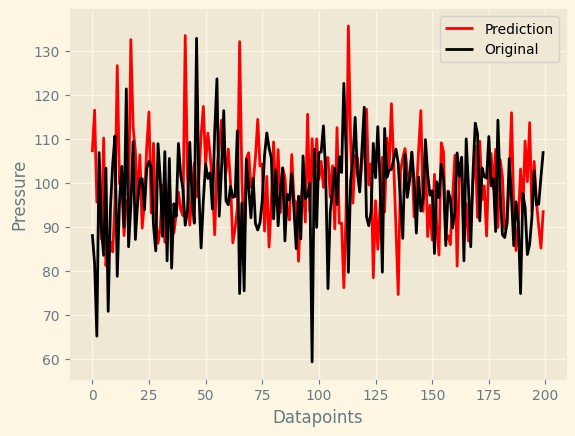

In [75]:
#Date where another failure occured
st_test = df_sin.loc[df_sin['datetime']=="2015-05-21"].index.values[0]

#Filtering data to include approximately two-weeks window
start_period_test = st_test - 7*24
end_period_test = st_test + 7*24
X_test, y_test, test_scaler= create_features(start_period_test, end_period_test)

#Shaping the sequence
X_test_seq = shape_sequence(X_test, 5, 0)
y_test_seq = shape_sequence(y_test, 1, 0)

#Predicting the testing data
y_pred_test = model.predict(X_test_seq)
test_er = mse(y_test_seq.reshape(-1,1), y_pred_test)
print("Testing Error = ", test_er.numpy())

#Selecting first 200 datapoints to allow for better plotting
#Returning the value using Inverse Transformation to allow better Observation
plt.plot(test_scaler.inverse_transform(y_pred_test[:200].reshape(-1,1)),'r', label="Prediction")
plt.plot(test_scaler.inverse_transform(y_test_seq[:200].reshape(-1,1)),'k', label="Original")
plt.ylabel("Pressure")
plt.xlabel("Datapoints")
plt.legend()
plt.show()

***We Observe that model can predict the sensor reading even in the event of machine failure, so we have to make sure the training data that we use to train should include past failure events as well***

In [ ]:
numeric_columns = ['volt', 'rotate', 'pressure', 'vibration']
barycentre = np.array(telemetry_df[numeric_columns].median())

In [ ]:
!pip install POT

In [ ]:
series = telemetry_df.reset_index(drop=True)
series

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
2,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864
3,2015-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372
4,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803
...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,96,157.157424,380.691266,102.885777,35.445739
876096,2016-01-01 06:00:00,97,159.607756,458.143799,100.945230,40.011599
876097,2016-01-01 06:00:00,98,165.717790,501.520194,114.553412,37.696504
876098,2016-01-01 06:00:00,99,168.439623,427.990029,107.899979,44.193151


In [ ]:
#Failure record of Machine 10
sel_fail = failure_df
pd.DataFrame(sel_fail)

,datetime,machineID,failure
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1
...,...,...,...
756,2015-12-30 06:00:00,88,comp1
757,2015-12-31 06:00:00,15,comp4
758,2015-12-31 06:00:00,64,comp1
759,2015-12-31 06:00:00,90,comp1


In [ ]:
#Error Record of Machine 10
sel_err = errors_df
pd.DataFrame(sel_err)

,datetime,machineID,errorID
0,2015-01-01 06:00:00,24,error1
1,2015-01-01 06:00:00,73,error4
2,2015-01-01 06:00:00,81,error1
3,2015-01-01 07:00:00,43,error3
4,2015-01-01 08:00:00,14,error4
...,...,...,...
3914,2015-12-31 18:00:00,91,error4
3915,2015-12-31 20:00:00,23,error3
3916,2015-12-31 23:00:00,94,error3
3917,2016-01-01 05:00:00,8,error3


In [ ]:
def create_feature(series, start, end):
    """
    Create features from a given time series data between start and end dates.
    The features include normalized pressure and one-hot encoded hours.

    Parameters:
    series (pd.DataFrame): DataFrame containing 'pressure' and 'datetime' columns.
    start (str): Start date for the feature creation.
    end (str): End date for the feature creation.

    Returns:
    np.array: Array of features.
    """
    # Extracting pressure and datetime values
    pressure = series.loc[start: end, 'pressure']
    timestamp = pd.to_datetime(series.loc[start: end, 'datetime'])

    # One-hot encoding for hours
    hours = timestamp.dt.hour
    hours_onehot = pd.get_dummies(hours).to_numpy()

    # Normalizing pressure values
    scaler = MinMaxScaler()
    normalized_pressure = scaler.fit_transform(pressure.values.reshape(-1, 1))

    # Combining normalized pressure and one-hot encoded hours
    features = np.concatenate([normalized_pressure, hours_onehot], axis=1)

    # Defining the target variable (y)
    y = features[5:, 0].reshape(-1, 1)

    return y

In [ ]:
taille_intervalle = 100
limite_inferieure = 0
limite_superieure = 876100

tableau_intervalles = []

# Remplir le tableau avec des intervalles successifs
for debut_intervalle in range(limite_inferieure, limite_superieure, taille_intervalle):
    fin_intervalle = min(debut_intervalle + taille_intervalle, limite_superieure)
    intervalle = (debut_intervalle, fin_intervalle - 1)  # La fin d'intervalle est exclusive
    tableau_intervalles.append(intervalle)

print(tableau_intervalles)


[(0, 99), (100, 199), (200, 299), (300, 399), (400, 499), (500, 599), (600, 699), (700, 799), (800, 899), (900, 999), (1000, 1099), (1100, 1199), (1200, 1299), (1300, 1399), (1400, 1499), (1500, 1599), (1600, 1699), (1700, 1799), (1800, 1899), (1900, 1999), (2000, 2099), (2100, 2199), (2200, 2299), (2300, 2399), (2400, 2499), (2500, 2599), (2600, 2699), (2700, 2799), (2800, 2899), (2900, 2999), (3000, 3099), (3100, 3199), (3200, 3299), (3300, 3399), (3400, 3499), (3500, 3599), (3600, 3699), (3700, 3799), (3800, 3899), (3900, 3999), (4000, 4099), (4100, 4199), (4200, 4299), (4300, 4399), (4400, 4499), (4500, 4599), (4600, 4699), (4700, 4799), (4800, 4899), (4900, 4999), (5000, 5099), (5100, 5199), (5200, 5299), (5300, 5399), (5400, 5499), (5500, 5599), (5600, 5699), (5700, 5799), (5800, 5899), (5900, 5999), (6000, 6099), (6100, 6199), (6200, 6299), (6300, 6399), (6400, 6499), (6500, 6599), (6600, 6699), (6700, 6799), (6800, 6899), (6900, 6999), (7000, 7099), (7100, 7199), (7200, 7299), 

In [ ]:
Y = []
for intervalle in tableau_intervalles:
  Y.append(create_feature(series, intervalle[0], intervalle[1]))

In [ ]:
import ot

distances = []

for y_val in Y:
  a = pres_scaler.inverse_transform(y_val.reshape(-1,1))
  b = np.tile(barycentre[2], (len(y_val), 1))

  # Calculate the cost matrix between the elements of a and b
  M = ot.dist(a, b, metric='euclidean')

  # Define the uniform distribution on a and b
  a_dist = ot.unif(len(a))
  b_dist = ot.unif(len(b))

  # Regularization term
  lambda_ = 1e-1  # You can adjust this parameter

  # Compute the Sinkhorn distance
  sinkhorn_distance = ot.sinkhorn2(a_dist, b_dist, M, lambda_)

  distances.append(sinkhorn_distance)


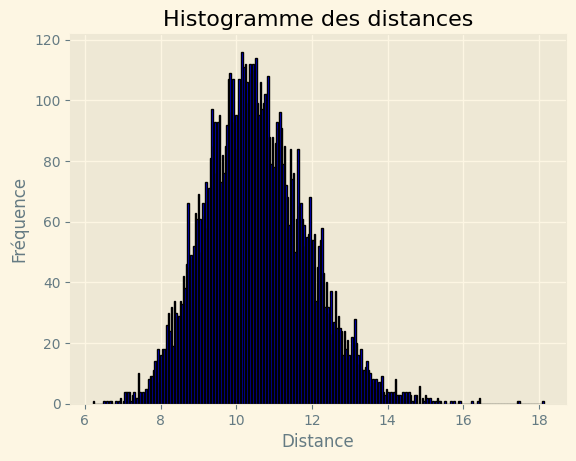

In [ ]:
import matplotlib.pyplot as plt

# Tracer l'histogramme
plt.hist(distances, bins=300, color='blue', edgecolor='black')

# Ajouter des labels et un titre
plt.xlabel('Distance')
plt.ylabel('Fréquence')
plt.title('Histogramme des distances')

# Afficher le graphique
plt.show()


In [ ]:
threshold = np.percentile(barycentre, 95)

In [ ]:
def detection_model(y_pred, barycentre, threshold):
  a = pres_scaler.inverse_transform(y_val.reshape(-1,1))
  b = np.tile(barycentre[2], (len(y_val), 1))

  # Calculate the cost matrix between the elements of a and b
  M = ot.dist(a, b, metric='euclidean')

  # Define the uniform distribution on a and b
  a_dist = ot.unif(len(a))
  b_dist = ot.unif(len(b))

  # Regularization term
  lambda_ = 1e-1  # You can adjust this parameter

  # Compute the Sinkhorn distance
  sinkhorn_distance = ot.sinkhorn2(a_dist, b_dist, M, lambda_)
  if sinkhorn_distance < threshold:
    return 1
  return -1

In [ ]:
detection_model(y_pred, barycentre, threshold)

1